In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import graphics as g

In [131]:
cell = "2d21b861"
epoch_idx = [5]
epochs = []
for e in epoch_idx:
    with open(f"../build/{cell}_{e:02}.pprox", "rt") as fp:
        epochs.append(json.load(fp))
epoch = epochs[0]

In [132]:
epoch["pprox"][1]

{'index': 1,
 'offset': 6.0,
 'events': [],
 'interval': [0.0, 6.0],
 'temperature': 28.698410034179688,
 'stimulus': {'I': 6.274208068847656,
  'interval': [0.19374000000000002, 2.19374]},
 'steps': {'I': [-1.5990991592407227,
   6.274208068847656,
   -21.58169937133789,
   -41.412960052490234,
   -1.596179723739624],
  'V': [-83.82108306884766,
   -81.50471496582031,
   -91.76993560791016,
   -97.58121490478516,
   -83.34162139892578]},
 'spont_interval': [2.19374, 4.69374],
 'Rs': 20.994171899477575,
 'Rm': 345.41249275207514,
 'Vm': -83.26873424209657}

In [133]:
sweeps = (pd.json_normalize(epochs, "pprox", ["cell", "epoch", "timestamp", "bird", "sire", ["stats", "tau"], ["stats", "Cm"]])
          .rename(columns={"index": "sweep", "stats.tau": "tau", "stats.Cm": "Cm"})
          .set_index(["cell", "epoch", "sweep"])
          .drop(columns=["offset", "interval"])
         )
sweeps.iloc[-1]

events                  [0.22354000000000002, 0.24600000000000002, 0.2...
temperature                                                     29.139933
spont_interval                                         [2.19374, 4.69374]
Rs                                                              15.837564
Rm                                                             263.767868
Vm                                                             -82.900578
stimulus.I                                                     150.290604
steps.I                 [-1.5884966850280762, 150.2906036376953, -21.5...
steps.V                 [-83.31957244873047, None, -89.07431030273438,...
stimulus.interval                          [0.19374000000000002, 2.19374]
first_spike.base                                               -50.046043
first_spike.thresh                                             -27.194786
first_spike.width                                                    1.88
first_spike.trough_t                  

In [134]:
sweeps.iloc[-1].events

[0.22354000000000002,
 0.24600000000000002,
 0.27434000000000003,
 0.33344,
 0.3788,
 0.45940000000000003,
 0.5392800000000001,
 0.7566400000000001,
 0.90114,
 1.02112,
 1.1322800000000002,
 1.2631000000000001,
 1.5518,
 1.7314200000000002,
 2.0110400000000004,
 2.1723000000000003]

In [135]:
cells = sweeps.reset_index()[["cell","bird", "sire"]].drop_duplicates().set_index("cell")

In [136]:
epochs = (
        sweeps.reset_index()[["cell","epoch","timestamp","tau","Cm"]]
        .drop_duplicates()
        .set_index(["cell", "epoch"])
)
ts = epochs.pop("timestamp").apply(pd.Timestamp)
epochs["time"] = ts.groupby(["cell"], group_keys=False).apply(lambda x: (x - x.iloc[0])).apply(lambda x: x.total_seconds())

In [137]:
sweep = sweeps.iloc[0]
def sweep_iv_stats(sweep):
    nsteps = len(sweep["steps.I"])
    return pd.Series(
        np.concatenate([sweep["steps.I"], sweep["steps.V"]]),
        index=pd.MultiIndex.from_product([["current", "voltage"], range(nsteps)], names=["value", "step"])
    )#.swaplevel().sort_index()
iv_stats = sweeps.apply(sweep_iv_stats, axis=1)
dev = (iv_stats.voltage - iv_stats.voltage.median()).abs()
v_dev = dev / dev.median()
bad_sweeps = (v_dev[[0,2,3,4]] > 10).any(axis=1)
iv_stats = iv_stats.loc[~bad_sweeps].stack("step")

In [138]:
iv_stats

value                         current    voltage
cell     epoch sweep step                       
2d21b861 5     0     0      -1.609727 -84.211212
                     1      -1.611402 -84.676460
                     2     -21.595819 -92.185081
                     3     -41.415634 -97.454796
                     4      -1.602308 -84.229546
...                               ...        ...
               19    0      -1.588497 -83.319572
                     1     150.290604        NaN
                     2     -21.575777 -89.074310
                     3     -41.395870 -93.823517
                     4      -1.587750 -82.724953

[100 rows x 2 columns]

In [139]:
v_dev

step                         0         1         2         3         4
cell     epoch sweep                                                  
2d21b861 5     0      3.490525  2.035213  1.051002  0.780541  2.008261
               1      2.079028  1.628634  0.768624  0.902226  0.161235
               2      0.353102  1.155032  0.661114  0.347005  0.228081
               3      2.294804  0.556264  0.818691  0.307040  0.057776
               4      0.810462  0.163790  0.989683  0.980789  3.069687
               5      5.816134  0.163790  1.458394  1.373486  2.044048
               6      2.526699  0.603474  1.173597  0.977470  1.636449
               7      4.174867  0.844968  1.034577  1.019211  2.486038
               8      1.641046  1.283131  0.228304  0.407062  0.233191
               9      0.397792       NaN  0.170836  0.294402  0.979353
               10     0.853440       NaN  0.202892  0.294402  1.020647
               11     0.264550  1.451256  0.170836  0.942477  1.086541
               12     1.664426       NaN  0.908676  1.645225  1.045659
               13     0.487944       NaN  1.131257  1.894757  0.671975
               14     3.291201       NaN  1.256348  2.627226  1.122694
               15     1.146560       NaN  1.064178  2.129727  0.047048
               16     0.503761       NaN  0.804031  2.871265  0.525746
               17     0.720613       NaN  1.010317  2.362427  0.047048
               18     0.582596       NaN  1.248486  2.408259  0.234445
               19     0.264550       NaN  1.064915  2.714763  1.121535

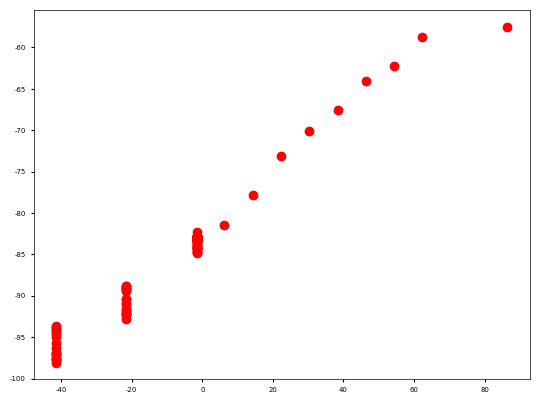

In [140]:
plt.plot(iv_stats.current, iv_stats.voltage, "ro")

0.35681234529388894

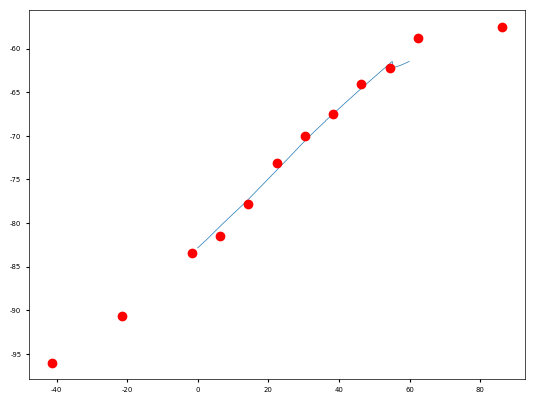

In [141]:
from loess.loess_1d import loess_1d
I_min = iv_stats.current.min()
I_max = iv_stats.current.max()
bins = pd.interval_range(np.floor(I_min), np.ceil(I_max))
cuts = pd.cut(iv_stats.current, bins)
binned = iv_stats.groupby(cuts).agg('mean').dropna()
xnew = np.arange(0, 60, 0.1)
#xnew = np.arange(I_min, I_max, 1.0)
xout, yout, wout = loess_1d(binned.current.to_numpy(), binned.voltage.to_numpy(), xnew=xnew, degree=1, frac=0.7, npoints=None, rotate=False, sigy=None)
smoothed = pd.DataFrame({"current": xout, "voltage": yout})
plt.plot(smoothed.current, smoothed.voltage)
plt.plot(binned.current, binned.voltage, "ro")
(smoothed.voltage.diff() / smoothed.current.diff()).mean()

In [101]:
iv_stats.index[0][0]

'2d21b861'

In [ ]:
def sweep_firing_stats(sweep):
    try:
        step = pd.Interval(*sweep["stimulus.interval"])
        spikes = [e for e in sweep.events if e in step]
        rate = len(spikes) / step.length
        if len(spikes) == 0:
            duration = np.nan
        elif len(spikes) == 1:
            duration = (
                sweep["first_spike.width"] + sweep["first_spike.trough_t"]
            ) / 1000.0
        else:
            duration = spikes[-1] - spikes[0]
    except TypeError:
        rate = duration = np.nan
    return pd.Series(
        {
            "current": sweep["stimulus.I"],
            "firing_rate": rate,
            "firing_duration": duration,
            "Rs": sweep.Rs,
            "Rm": sweep.Rm,
            "Vm": sweep.Vm,
            "temperature": sweep.temperature,
        }
    )

sweep_stats = sweeps.apply(sweep_firing_stats, axis=1)

In [ ]:
sweep_stats

In [ ]:
def epoch_stats(sweeps):
    # sweeps with spikes
    idx, = (sweep_stats.firing_rate > 0).to_numpy().nonzero()
    df = sweep_stats.iloc[idx[0]-1:]
    I_0 = (df.current[1] + df.current[0]) / 2
    slope = np.mean(np.diff(df.firing_rate) / np.diff(df.current))
    return pd.Series([
    sweeps.firing_duration.max(),
    sweeps.firing_duration.mean(),
    sweeps.firing_rate.max(),
        I_0,
        slope,
    sweeps.Rs.mean(),
    sweeps.Rm.mean(),
    sweeps.temperature.mean(),
    ], index=["duration_max", "duration_mean", "rate_max", "rheobase", "fI_slope", "Rs", "Rm", "T"])
epoch_stats(sweep_stats)

In [13]:
estats = pd.read_csv("../build/epoch_stats.csv", index_col=["cell", "epoch"])
estats

n_sweeps  n_spike_sweeps  duration_max  duration_mean  \
cell     epoch                                                          
01168501 3          16.0            10.0       1.87890       1.488602   
         4          16.0             2.0       0.04780       0.047800   
         5          16.0            12.0       1.81818       1.063490   
         6          16.0             8.0       0.90364       0.374700   
         7          16.0             8.0       0.28410       0.101669   
...                  ...             ...           ...            ...   
fee1b00f 9          20.0             4.0       0.10020       0.092667   
         10         20.0             2.0       0.09538       0.095380   
fff4cba9 2          19.0            10.0       1.73730       1.418503   
         3          20.0            20.0       1.83650       1.265451   
         4          20.0            18.0       1.86998       0.733091   

                duration_sd  rate_max    rheobase     slope         Rs  \
cell     epoch                                                           
01168501 3         0.458610       7.0   17.968865  0.257725  20.490840   
         4              NaN       0.5   41.895536  0.161714  20.315702   
         5         0.721221       2.5   20.980968  0.044879  20.587922   
         6         0.286744       1.5   49.430489  0.023739  21.678215   
         7         0.093603       1.5   57.963804  0.030617  22.279142   
...                     ...       ...         ...       ...        ...   
fee1b00f 9         0.012600       0.5  245.874863  0.011200  23.268712   
         10             NaN       0.5  275.690277  0.033667  25.316276   
fff4cba9 2         0.537524       5.5   17.508013  0.320184  20.908737   
         3         0.739617       6.0   -0.501836  0.146917  21.881139   
         4         0.633659       7.5    3.472384  0.024387  22.417500   

                   Rs_sd  ...  spike_width  spike_trough  n_evoked  n_spont  \
cell     epoch            ...                                                 
01168501 3      4.332397  ...     1.093333     45.488889      80.0      5.0   
         4      6.197584  ...     1.120000     46.680000       1.0      0.0   
         5      3.445783  ...     1.140000     43.623333      20.0      0.0   
         6      2.207937  ...     1.200000     41.620000      16.0      0.0   
         7      3.069982  ...     1.251429     41.457143      10.0      0.0   
...                  ...  ...          ...           ...       ...      ...   
fee1b00f 9      2.406651  ...     2.146667     90.520000       3.0      0.0   
         10     1.908420  ...     2.260000     93.120000       1.0      0.0   
fff4cba9 2      3.578530  ...     1.862500     72.267500      59.0      0.0   
         3      3.285047  ...     1.762500     62.766250     100.0      5.0   
         4      3.461072  ...     2.050000     59.286250      48.0     13.0   

                      tau          Cm         time  delta_Rs  delta_Rm  \
cell     epoch                                                           
01168501 3      23.117338   54.402705     0.000000  0.000000  0.000000   
         4      17.450993   68.432426   174.549999 -0.008547 -0.066646   
         5      21.410328   70.748362   282.735000  0.004738 -0.071775   
         6      16.837426   61.911734   395.954000  0.057947 -0.052360   
         7      14.403591   57.949709   515.546999  0.087273 -0.150365   
...                   ...         ...          ...       ...       ...   
fee1b00f 9      15.263543  103.257736  1059.479999  0.219150 -0.430162   
         10     14.678722  109.473885  1203.028999  0.326431 -0.449203   
fff4cba9 2      58.358273  129.235146     0.000000  0.000000  0.000000   
         3      52.383518  134.834830   231.216000  0.046507  0.010262   
         4      29.597214  141.233964   459.983000  0.072159 -0.288623   

                 delta_Vm  
cell     epoch             
01168501 3       0.000000  
         4      -1.890133  


In [22]:
df = estats.loc[cell]
(df["n_spont"] + df["n_evoked"]).shift(1, fill_value=0).cumsum()

epoch
2      0.0
3    215.0
4    270.0
5    339.0
6    361.0
7    400.0
dtype: float64

In [30]:
x = estats.groupby("cell", group_keys=False).apply(lambda df: (df["n_spont"] + df["n_evoked"]).shift(1, fill_value=0).cumsum()).rename("cum_spikes")

In [31]:
x

cell      epoch
01168501  3          0.0
          4         85.0
          5         86.0
          6        106.0
          7        122.0
                   ...  
fee1b00f  9        139.0
          10       142.0
fff4cba9  2          0.0
          3         59.0
          4        164.0
Name: cum_spikes, Length: 1105, dtype: float64

In [32]:
estats.join([x])

n_sweeps  n_spike_sweeps  duration_max  duration_mean  \
cell     epoch                                                          
01168501 3          16.0            10.0       1.87890       1.488602   
         4          16.0             2.0       0.04780       0.047800   
         5          16.0            12.0       1.81818       1.063490   
         6          16.0             8.0       0.90364       0.374700   
         7          16.0             8.0       0.28410       0.101669   
...                  ...             ...           ...            ...   
fee1b00f 9          20.0             4.0       0.10020       0.092667   
         10         20.0             2.0       0.09538       0.095380   
fff4cba9 2          19.0            10.0       1.73730       1.418503   
         3          20.0            20.0       1.83650       1.265451   
         4          20.0            18.0       1.86998       0.733091   

                duration_sd  rate_max    rheobase     slope         Rs  \
cell     epoch                                                           
01168501 3         0.458610       7.0   17.968865  0.257725  20.490840   
         4              NaN       0.5   41.895536  0.161714  20.315702   
         5         0.721221       2.5   20.980968  0.044879  20.587922   
         6         0.286744       1.5   49.430489  0.023739  21.678215   
         7         0.093603       1.5   57.963804  0.030617  22.279142   
...                     ...       ...         ...       ...        ...   
fee1b00f 9         0.012600       0.5  245.874863  0.011200  23.268712   
         10             NaN       0.5  275.690277  0.033667  25.316276   
fff4cba9 2         0.537524       5.5   17.508013  0.320184  20.908737   
         3         0.739617       6.0   -0.501836  0.146917  21.881139   
         4         0.633659       7.5    3.472384  0.024387  22.417500   

                   Rs_sd  ...  spike_trough  n_evoked  n_spont        tau  \
cell     epoch            ...                                               
01168501 3      4.332397  ...     45.488889      80.0      5.0  23.117338   
         4      6.197584  ...     46.680000       1.0      0.0  17.450993   
         5      3.445783  ...     43.623333      20.0      0.0  21.410328   
         6      2.207937  ...     41.620000      16.0      0.0  16.837426   
         7      3.069982  ...     41.457143      10.0      0.0  14.403591   
...                  ...  ...           ...       ...      ...        ...   
fee1b00f 9      2.406651  ...     90.520000       3.0      0.0  15.263543   
         10     1.908420  ...     93.120000       1.0      0.0  14.678722   
fff4cba9 2      3.578530  ...     72.267500      59.0      0.0  58.358273   
         3      3.285047  ...     62.766250     100.0      5.0  52.383518   
         4      3.461072  ...     59.286250      48.0     13.0  29.597214   

                        Cm         time  delta_Rs  delta_Rm   delta_Vm  \
cell     epoch                                                           
01168501 3       54.402705     0.000000  0.000000  0.000000   0.000000   
         4       68.432426   174.549999 -0.008547 -0.066646  -1.890133   
         5       70.748362   282.735000  0.004738 -0.071775  -3.087424   
         6       61.911734   395.954000  0.057947 -0.052360  -3.641493   
         7       57.949709   515.546999  0.087273 -0.150365  -5.005551   
...                    ...          ...       ...       ...        ...   
fee1b00f 9      103.257736  1059.479999  0.219150 -0.430162  -7.286924   
         10     109.473885  1203.028999  0.326431 -0.449203  -7.176008   
fff4cba9 2      129.235146     0.000000  0.000000  0.000000   0.000000   
         3      134.834830   231.216000  0.046507  0.010262   7.613481   
         4      141.233964   459.983000  0.072159 -0.288623  19.740276   

                cum_spikes  
cell     epoch              
01168501 3             0.0  
         4            85.0  
         5            